In [1]:
import numpy as np
import pandas as pd
from utils import read_q_mat, read_a_mat
import scipy.io
from sim import (
    model_setup,
    sim_hb,
    std_operating_policy,
    max_release,
    min_release,
    level_to_storage,
)
import matplotlib.pyplot as plt
import seaborn as sns
from metrics import OF_flood, OF_hydro
import os
from process_policy import find_best_policy, plot_policy, process_policy, plot_policy_ts
from itertools import product

from dotenv import load_dotenv


import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set_context("paper", font_scale=1.4)
plt.rcParams['figure.figsize'] = [12, 8]

# Current performance quantification
## Setting up the model


In [3]:
start_date = "1994-11-01"
end_date = "2007-01-01"
q_vu = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_vuquang.mat"
q_ye = "/Users/cooper/Desktop/optimal-wat-allocation/data/q_yenbai.mat"
a = "/Users/cooper/Desktop/optimal-wat-allocation/data/a_hoabinh_K.mat"

qq, sys_params = model_setup(
    ini_date=start_date,
    fin_date=end_date,
    path_a_hoabinh_K=a,
    path_q_vuquang=q_vu,
    path_q_yenbai=q_ye,
)

## Plotting the current control policy


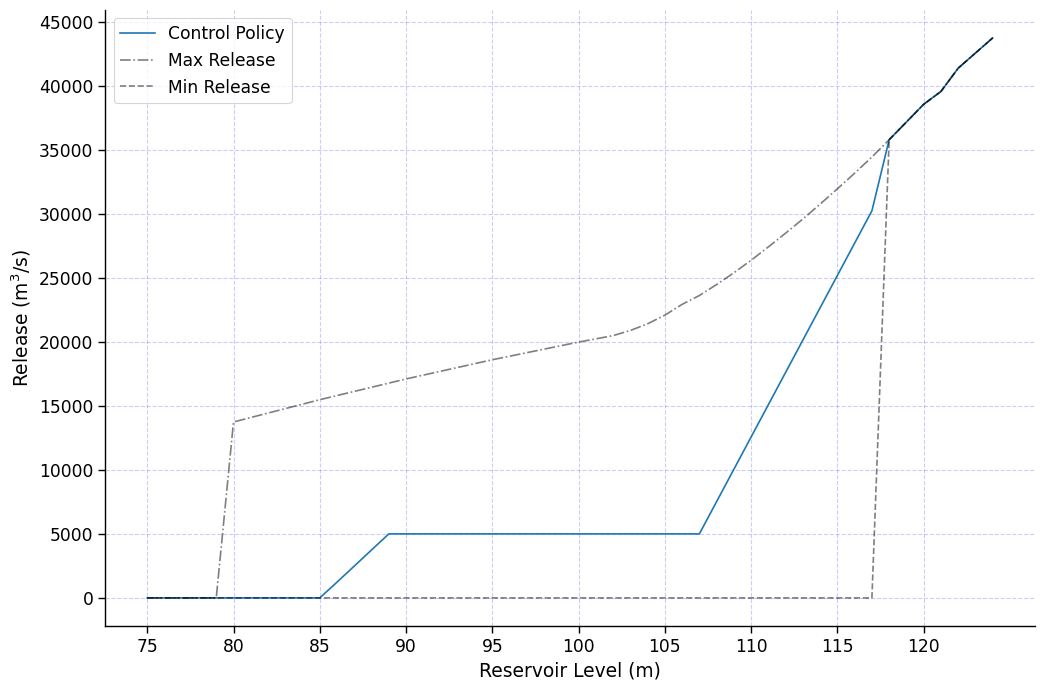

In [4]:
control_policy = (89, 107, 1.57, 1.5704, 5000)



plot_policy(policies=[control_policy],
            sys_params=sys_params,
            names=["Control Policy"],
            output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/control_policy.png",)

## Plotting the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.


In [5]:
control_policy_simul = process_policy(
    path_to_policy="/Users/cooper/Desktop/optimal-wat-allocation/data/simHB_output.csv",
    start_date=start_date,
    end_date=end_date,
)

control_policy_simul = control_policy_simul["1995":"2006"]
control_policy_simul

,ReservoirLevel,ReleaseDecision,Release,WaterLevelHanoi
Date,,,,
1995-01-01,85.643921,785.551161,804.235152,3.415327
1995-01-02,85.614685,748.837769,785.551161,3.411999
1995-01-03,85.606837,738.982871,748.837769,3.348751
1995-01-04,85.626696,763.921157,738.982871,3.364501
1995-01-05,85.741300,907.836437,763.921157,3.667345
...,...,...,...,...
2006-12-27,85.419935,504.277673,514.862006,2.051027
2006-12-28,85.411271,493.397313,504.277673,2.040744
2006-12-29,85.390629,467.476096,493.397313,2.148142


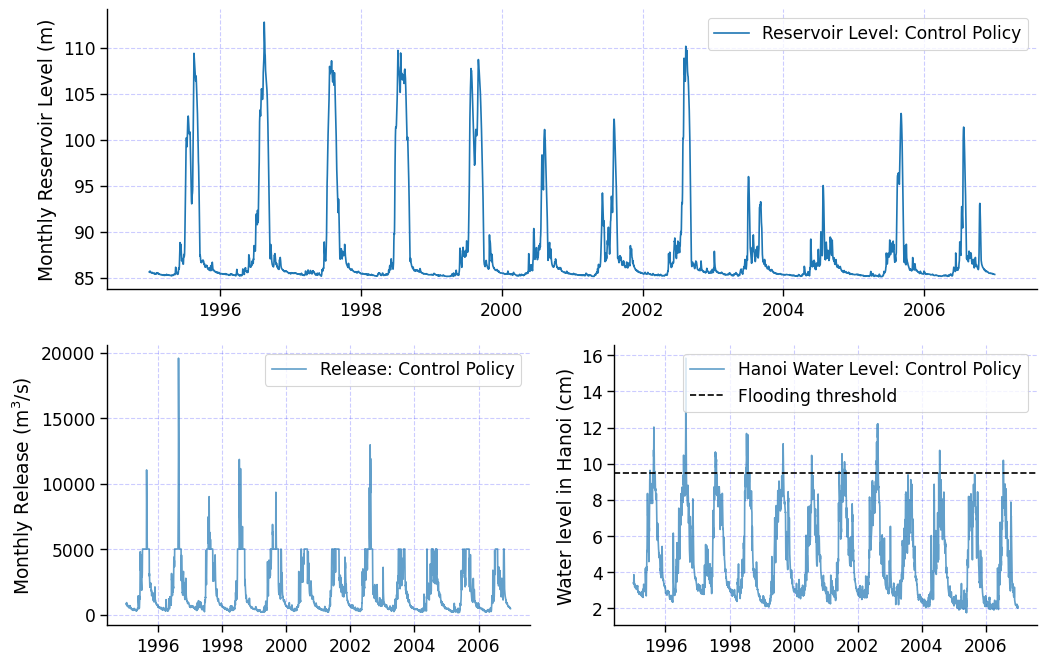

In [6]:
policy1 = plot_policy_ts(
    [control_policy_simul],
    ["Control Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/control_policy_TS.png",
)

## Computing the current performance in the two operating objectives


In [7]:
j_flood = OF_flood(control_policy_simul["WaterLevelHanoi"] * 100)

j_hydro = OF_hydro(
    qq["q_Da"]["1995":"2006"],
    control_policy_simul["Release"],
    control_policy_simul["ReservoirLevel"],
)

print(f"j_flood: {j_flood} [cm2]")
print(f"j_hydro: {j_hydro} [GWh/d]")

j_flood: 525.77 [cm2]
j_hydro: 16.73 [GWh/d]


# Exhaustive optimisation on a Finite Policy Parameters Set
## Creating the set of policy parameters

In [8]:
h1 = 89
h2_values = [100, 105, 110, 115]
m1 = 1.57
m2_values = [1.56, 1.565, 1.57]
w_values = [500, 1000, 1500, 2000, 3000, 8000, 13000]

combinations = list(product([h1], h2_values, [m1], m2_values, w_values))


policies_df = pd.DataFrame(combinations, columns=["h1", "h2", "m1", "m2", "w"])

policies_df["Policy"] = policies_df.apply(tuple, axis=1)
policies_df = policies_df[["Policy"]]

policies_df

,Policy
0,"(89.0, 100.0, 1.57, 1.56, 500.0)"
1,"(89.0, 100.0, 1.57, 1.56, 1000.0)"
2,"(89.0, 100.0, 1.57, 1.56, 1500.0)"
3,"(89.0, 100.0, 1.57, 1.56, 2000.0)"
4,"(89.0, 100.0, 1.57, 1.56, 3000.0)"
...,...
79,"(89.0, 115.0, 1.57, 1.57, 1500.0)"
80,"(89.0, 115.0, 1.57, 1.57, 2000.0)"
81,"(89.0, 115.0, 1.57, 1.57, 3000.0)"
82,"(89.0, 115.0, 1.57, 1.57, 8000.0)"


## Finding the best policy for hydropower, the best for flood control, and the best compromise

In [9]:
compromise = find_best_policy(
    criteria="compromise",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

compromise_policy = policies_df.iloc[compromise['policy']-1]['Policy']


flood = find_best_policy(
    criteria="flood",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

flood_policy = policies_df.iloc[flood['policy']-1]['Policy']

hydro = find_best_policy(
    criteria="hydro",
    start_date=start_date,
    end_date=end_date,
    qq=qq,
    folder_name="84_policies",
)

hydro_policy = policies_df.iloc[hydro['policy']-1]['Policy']

In [10]:
hydro_policy

(89.0, 105.0, 1.57, 1.565, 500.0)

## Getting the simulation time series

In [11]:
compromise_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{compromise['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

compromise_policy_simul = compromise_policy_simul["1995":"2006"]

flood_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{flood['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

flood_policy_simul = flood_policy_simul["1995":"2006"]

hydro_policy_simul = process_policy(
    path_to_policy=f"/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_{hydro['policy']}.csv",
    start_date=start_date,
    end_date=end_date,
)

hydro_policy_simul = hydro_policy_simul["1995":"2006"]


## Plotting all three policies and the time series of simulated reservoir level, release, and water level in Hanoi for the period 1995-2006.

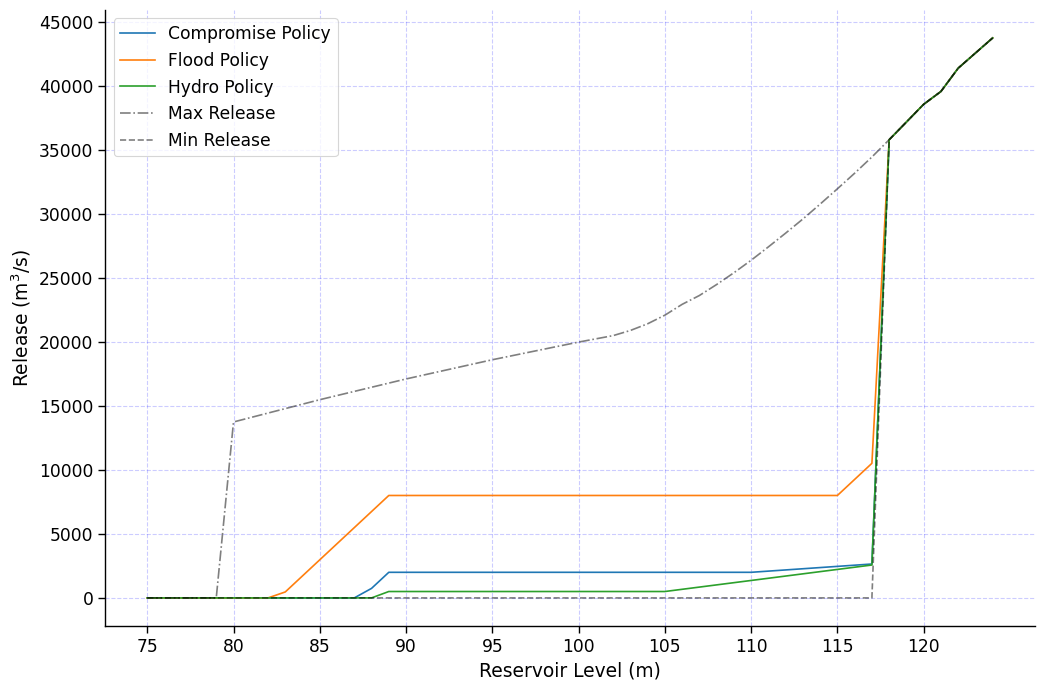

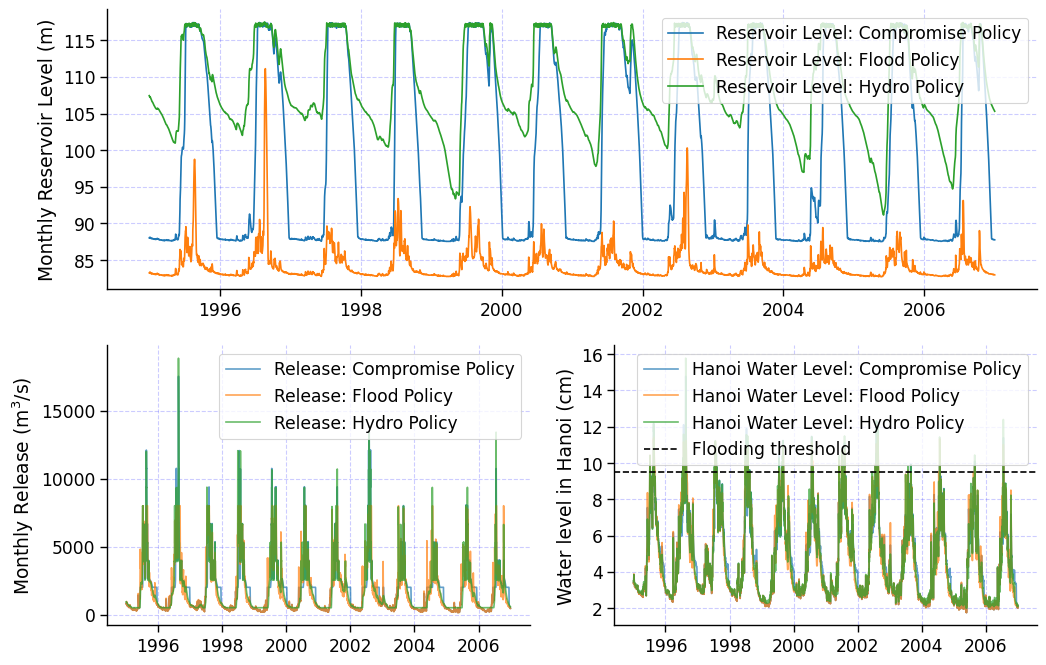

In [12]:
plot_policy(
    policies=[compromise_policy, flood_policy, hydro_policy],
    sys_params=sys_params,
    output_destination="/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_policies.png",
    names=["Compromise Policy", "Flood Policy", "Hydro Policy"],
)

plot_policy_ts(
    [compromise_policy_simul, flood_policy_simul, hydro_policy_simul],
    ["Compromise Policy", "Flood Policy", "Hydro Policy"],
    "/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_TS.png",
)

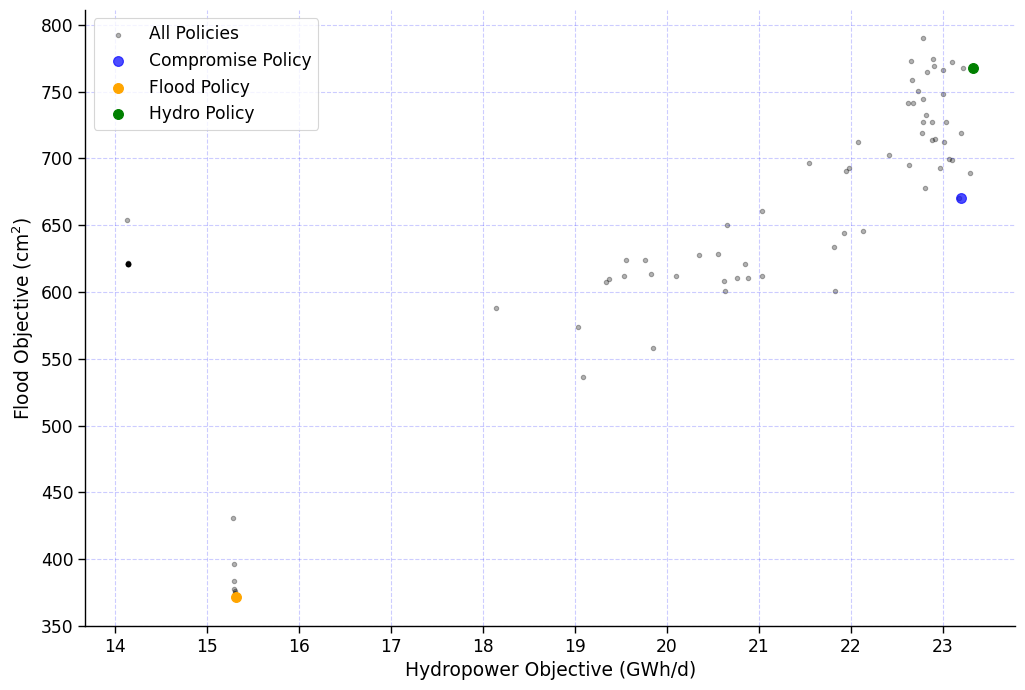

In [13]:
df = pd.read_csv('/Users/cooper/Desktop/optimal-wat-allocation/84_policies/policy_summary.csv')

df = df.iloc[:,-2:].reset_index(drop=True)

output_destination = "/Users/cooper/Desktop/optimal-wat-allocation/images/compromise_flood_hydro_policies_scatter.png"

plt.scatter(df['Hydropower Objective'], df['Flood Objective'], c='black', s=10, alpha=0.3, label='All Policies')
plt.scatter(compromise['OF_hydro'], compromise['OF_flood'], c='#0000FF', s=50, label='Compromise Policy', alpha=0.7)
plt.scatter(flood['OF_hydro'], flood['OF_flood'], c='orange', s=50, label='Flood Policy')
plt.scatter(hydro['OF_hydro'], hydro['OF_flood'], c='green', s=50, label='Hydro Policy')
plt.xlabel('Hydropower Objective (GWh/d)')
plt.ylabel('Flood Objective (cm$^2$)')
sns.despine()
plt.legend()
plt.grid(alpha=0.2, linestyle="--", color="#0000FF")

plt.xticks(range(14, 24, 1))
plt.yticks(range(350, 850, 50))
plt.savefig(output_destination, bbox_inches='tight', dpi=300)
plt.show()


In [14]:
compromise

{'policy': 46, 'OF_flood': 670.55, 'OF_hydro': 23.2, 'criteria': 'compromise'}

## Optimization via Evolutionary Multi-Objective Direct Policy Search

In [15]:
def load_and_concat_data(
    filenames: list[str], columns: list[str], folder_path: str
) -> pd.DataFrame:
    """
    Load CSV files, concatenate them into a single DataFrame, and drop duplicates.

    Parameters:
    - filenames: list of filenames to load
    - columns: list of column names
    - folder_path: path to folder containing CSV files

    Returns:
    - combined_data: concatenated DataFrame
    """
    combined_data = pd.DataFrame(columns=columns)

    for filename in filenames:
        df = pd.read_csv(os.path.join(folder_path, f"{filename}.csv"), header=None)
        df.columns = columns

        combined_data = pd.concat([combined_data, df]).reset_index(drop=True)
        combined_data.drop_duplicates(inplace=True, subset=['h2', 'm2', 'w', 'OF_flood', 'OF_hydro'])

    return combined_data

In [16]:
chrfs= ['chrf', 'chrf1', 'chrf2', 'chrf3']
columns = ['h2', 'm2', 'w', 'OF_flood', 'OF_hydro', 'output1', 'output3']

load_dotenv()

workspace = os.getenv("WORKSPACE")
genoptdata = os.getenv("GENOPTDATA")

path_to_folder = os.path.join(workspace, genoptdata)

gen_opt_policies = load_and_concat_data(chrfs, columns, path_to_folder)
gen_opt_policies['OF_hydro'] = - gen_opt_policies['OF_hydro'] 

In [17]:
gen_opt_policies.head()

,h2,m2,w,OF_flood,OF_hydro,output1,output3
0,102.86,1.5601,5450.7,178.75,14.633,1,inf
1,104.45,1.5600,1195.2,748.41,22.946,1,inf
2,114.90,1.5684,4178.2,447.76,16.206,1,0.65271
3,105.81,1.5606,2989.1,566.55,19.183,1,0.64323
4,106.11,1.5608,2912.2,588.97,19.492,1,0.23061


In [18]:
chros= ['chr0', 'chr01', 'chr02', 'chr03']
columns = ['h2', 'm2', 'w', 'OF_flood', 'OF_hydro']

gen_init_policies = load_and_concat_data(chros, columns, path_to_folder)
gen_init_policies['OF_hydro'] = - gen_init_policies['OF_hydro'] 

## Plot all 'suboptimal' policies and and the pareto front

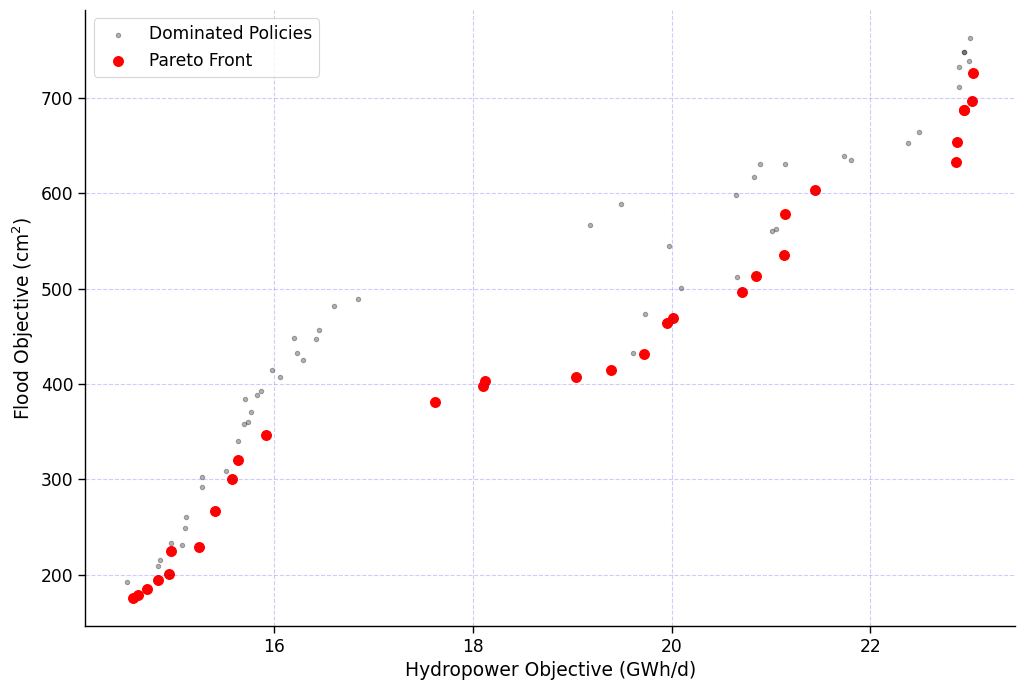

In [20]:
def find_pareto_frontier(df: pd.DataFrame, x: str, y: str) -> pd.DataFrame:
    """
    Find the Pareto frontier of a DataFrame with two objectives.

    Parameters:
    - df: DataFrame with two objectives
    - x: name of the first objective
    - y: name of the second objective

    Returns:
    - pareto_frontier: DataFrame containing the Pareto frontier
    """
    pareto_frontier = []

    for i, row in df.iterrows():
        if not any((df[x] > row[x]) & (-df[y] > -row[y])):
            pareto_frontier.append(row)

    pareto_frontier = pd.DataFrame(pareto_frontier, columns=df.columns)
    return pareto_frontier


pareto_frontier = find_pareto_frontier(gen_opt_policies, "OF_hydro", "OF_flood")

plt.scatter(
    gen_opt_policies["OF_hydro"],
    gen_opt_policies["OF_flood"],
    c="black",
    s=10,
    alpha=0.3,
    label="Dominated Policies",
)
plt.scatter(
    pareto_frontier["OF_hydro"],
    pareto_frontier["OF_flood"],
    c="red",
    s=50,
    label="Pareto Front",
)

plt.xlabel("Hydropower Objective (GWh/d)")
plt.ylabel("Flood Objective (cm$^2$)")
sns.despine()
plt.legend()
plt.grid(alpha=0.2, linestyle="--", color="#0000FF")


plt.show()